## Introduction
In this assignment, you will learn how to build a language model from scratch and use the model to generate new text.
You will also see how training a language model helps you learn word representation.

Note: 
- Plagiarism will result in 0 mark.
- The following template shows how your code should look like. You are free to add more functions, change the parameters. You are not allowed to use existing implementations.


In [1]:
import torch
import torch.nn as nn
import torch.autograd as ag
import numpy as np
from matplotlib import pyplot as plt
import math 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Recurrent Neural Network (5 points)
To begin, you have to implement the vanila RNN in Pytorch.

### Vanila RNN
Recall the formula for vanila RNN:
        \begin{eqnarray}
        h_t & = & \sigma(W_h h_{t-1} + W_x x_t + b_1) \\
        y_t & = & \phi(W_y h_t + b_2)
        \end{eqnarray}
where $\sigma$ is the usually the sigmoid activation function and $\phi$ is usually the softmax function.

Hints:
For RNNLM, the input is a squence of word_id, e.g. [10, 8, 5, 2, 101, 23]. You have to convert each word_id to an embedding vector. To implement this, you can use the `torch.nn.Embedding` class.

In [2]:
class VanilaRNNLM(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_outputs, vocab, sigma='sigmoid', phi='softmax'):
        """
        Construct a vanila RNN. 
        
        Params:
        n_inputs: number of input neurons = embedding_dim
        n_hiddens: number of hidden neurons 
        n_outputs: number of output neurons = vocab_size
        vocab: a dictionary of the form {word: word_id}
        sigma: activation function for hidden layer
        phi: output function
        """
        super(VanilaRNNLM, self).__init__()

        self.embeddings = nn.Embedding(n_outputs, n_inputs)
        self.n_hiddens = n_hiddens
        self.vocab = vocab

        self.W_e = nn.Parameter(torch.Tensor(n_inputs, n_hiddens).to(device))
        self.W_h = nn.Parameter(torch.Tensor(n_hiddens, n_hiddens).to(device))
        self.b1 = nn.Parameter(torch.zeros(1, n_hiddens).to(device))
        
        self.W_y = nn.Parameter(torch.Tensor(n_hiddens, n_outputs).to(device))
        self.b2 = nn.Parameter(torch.zeros(1, n_outputs))

        # initialize weights
        nn.init.uniform_(self.embeddings.weight, -1.0, 1.0)
        nn.init.xavier_normal_(self.W_e)
        nn.init.xavier_normal_(self.W_h)
        nn.init.xavier_normal_(self.W_y)

    
    def forward(self, xs, h0):
        """
        Params:
        xs: the input sequence [x_1, x_2, ..., x_n]. x_i is the id of the i-th word in the sequence. 
            For example, xs = [1, 3, 11, 6, 8, 2]
        h0: the initial hidden state
        
        Returns: (ys, hs) where
        ys = [y_1, y_2, ..., y_n] and
        hs = [h_1, h_2, ..., h_n]
        """
        # embedded sequence [e_1, e_2, ..., e_n]    n x embedding_dim
        es = self.embeddings(xs)  
        #.view((1, -1))

        Time_steps = len(es)
        hs = []
        ys = []

        for t in range(Time_steps):
          if (t==0):
            # h_1 = sigmoid(W_h * h0 + W_e * e_1 + b1)  
            h_t = torch.matmul(h0, self.W_h) + torch.matmul(es[t], self.W_e)  + self.b1
            h_t = torch.sigmoid(h_t)
            hs.append(h_t)
          else:
            # h_t = sigmoid(W_h * h_(t-1) + W_e * e_t + b1)  
            h_t = torch.matmul(hs[t-1], self.W_h) + torch.matmul(es[t], self.W_e)  + self.b1
            h_t = torch.sigmoid(h_t)
            hs.append(h_t)
          # y_t = softmax(W_y * h_t + b2)
          y_t = torch.matmul(hs[t], self.W_y) + self.b2
          ys.append(y_t)

        return ys, hs
        

### Fancy RNN
Vanila RNN suffers from the gradient vanishing/exploding problem. Your next task is to implement a more sophisticated RNN that is more robust to gradient vanishing/exploding.

By reducing the vanishing gradient problem, the LSTM architecture makes it easier for the RNN to preserve information from many previous timesteps. So that the LSTM can learn long-distance dependencies.

$$ f^{(t)} = \sigma(W_f h^{(t-1)} + U_f x^{(t)} + b_f) $$
$$ i^{(t)} = \sigma(W_i h^{(t-1)} + U_i x^{(t)} + b_i) $$
$$ o^{(t)} = \sigma(W_o h^{(t-1)} + U_o x^{(t)} + b_o) $$

$$ g^{(t)} = \tanh(W_c h^{(t-1)} + U_c x^{(t)} + b_c) $$
$$ c^{(t)} = f^{(t)} \odot c^{(t-1)} + i^{(t)} \odot \tilde{c}^{(t)} $$
$$ h^{(t)} = o^{(t)} \odot \tanh c^{(t)} $$

In [3]:
class FancyRNNLM(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_outputs, n_layers, vocab, sigma='sigmoid', phi='softmax'):
        """
        Construct a fancy RNN, this could be LSTM, GRU, or your own invention.
        
        Params:
        n_inputs: number of input neurons
        n_hiddens: number of hidden neurons
        n_outputs: number of output neurons
        vocab: a dictionary {word: word_id}
        sigma: activation function for hidden layer
        phi: output function
        """
        super(FancyRNNLM, self).__init__()

        self.embeddings = nn.Embedding(n_outputs, n_inputs)
        self.n_hiddens = n_hiddens
        self.vocab = vocab

        self.W_f = nn.Parameter(torch.Tensor(n_hiddens, n_hiddens).to(device))
        self.U_f = nn.Parameter(torch.Tensor(n_inputs, n_hiddens).to(device))
        self.b_f = nn.Parameter(torch.zeros(1, n_hiddens).to(device))
        
        self.W_i = nn.Parameter(torch.Tensor(n_hiddens, n_hiddens).to(device))
        self.U_i = nn.Parameter(torch.Tensor(n_inputs, n_hiddens).to(device))
        self.b_i = nn.Parameter(torch.zeros(1, n_hiddens).to(device))

        self.W_o = nn.Parameter(torch.Tensor(n_hiddens, n_hiddens).to(device))
        self.U_o = nn.Parameter(torch.Tensor(n_inputs, n_hiddens).to(device))
        self.b_o = nn.Parameter(torch.zeros(1, n_hiddens).to(device))

        self.W_g = nn.Parameter(torch.Tensor(n_hiddens, n_hiddens).to(device))
        self.U_g = nn.Parameter(torch.Tensor(n_inputs, n_hiddens).to(device))
        self.b_g = nn.Parameter(torch.zeros(1, n_hiddens).to(device))

        self.fc = nn.Linear(n_hiddens, n_outputs)

        # initialize weights
        nn.init.uniform_(self.embeddings.weight, -1.0, 1.0)
        nn.init.xavier_normal_(self.W_f)
        nn.init.xavier_normal_(self.U_f)
        nn.init.xavier_normal_(self.W_i)
        nn.init.xavier_normal_(self.U_i)
        nn.init.xavier_normal_(self.W_o)
        nn.init.xavier_normal_(self.U_o)
        nn.init.xavier_normal_(self.W_g)
        nn.init.xavier_normal_(self.U_g)

    def forward(self, xs, h0):

        es = self.embeddings(xs)  

        Time_steps = len(es)
        cs = []
        hs = []
        ys = []
        c0 = torch.zeros(1, self.n_hiddens).to(device)

        for t in range(Time_steps):
          if (t==0):
            f_t = torch.sigmoid(torch.matmul(h0, self.W_f) + torch.matmul(es[t], self.U_f)  + self.b_f)
            i_t = torch.sigmoid(torch.matmul(h0, self.W_i) + torch.matmul(es[t], self.U_i)  + self.b_i)
            o_t = torch.sigmoid(torch.matmul(h0, self.W_o) + torch.matmul(es[t], self.U_o)  + self.b_o)
            # g_t = tanh(W_g * h_(t-1) + U_g * e_t + b_g) 
            g_t = torch.tanh(torch.matmul(h0, self.W_g) + torch.matmul(es[t], self.U_g)  + self.b_g)
            c_t = f_t * c0 + i_t * g_t
            cs.append(c_t)
            h_t = o_t * torch.tanh(c_t)
            hs.append(h_t)
          else:
            # f_t = sigmoid(W_f * h_(t-1) + W_f * e_t + b_f)  
            f_t = torch.sigmoid(torch.matmul(hs[t-1], self.W_f) + torch.matmul(es[t], self.U_f)  + self.b_f)
            i_t = torch.sigmoid(torch.matmul(hs[t-1], self.W_i) + torch.matmul(es[t], self.U_i)  + self.b_i)
            o_t = torch.sigmoid(torch.matmul(hs[t-1], self.W_o) + torch.matmul(es[t], self.U_o)  + self.b_o)
            # g_t = tanh(W_g * h_(t-1) + U_g * e_t + b_g) 
            g_t = torch.tanh(torch.matmul(hs[t-1], self.W_g) + torch.matmul(es[t], self.U_g)  + self.b_g)
            c_t = f_t * cs[t-1] + i_t * g_t
            cs.append(c_t)
            h_t = o_t * torch.tanh(c_t)
            hs.append(h_t)
          y_t = self.fc(h_t)
          ys.append(y_t)

        return ys, hs

## Language Modeling with RNN (4 points)
The next step is to use our RNNs in some real world tasks. One of the most common application of RNN is language modeling.

### Data
For this assignment, we will use text data from Wikipedia. To start, download the data from this website:

https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip

Some information about this dataset can be found here:

https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/



In [ ]:
from zipfile import ZipFile

# download the data
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip -P "/content/"

with ZipFile('/content/wikitext-103-v1.zip', 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

In [31]:
from pathlib import Path
import re

train_data = Path('/content/wikitext-103/wiki.test.tokens').read_text()

### Preprocess Data

In [32]:
# Divide heading and article of training set
heading_pattern = '( \n \n = [^=]*[^=] = \n \n )'
breakline = ' \n'
train_data = breakline + train_data
train_split = re.split(heading_pattern, train_data)
train_headings = [x for x in train_split[1::2]]
train_articles = [x for x in train_split[2::2]]

print(train_headings[0])
print(train_articles[0][:100])
print(len(train_articles))

 
 
 = Robert Boulter = 
 
 
Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role 
60


In [33]:
# tokenization + lowercasing
train_articles_token = [article.lower().split() for article in train_articles]

print(train_articles_token[0][:10]) 

['robert', 'boulter', 'is', 'an', 'english', 'film', ',', 'television', 'and', 'theatre']


In [34]:
# create vocabulary
vocabulary = []
for sentence in train_articles_token:
  for token in sentence:
    if token not in vocabulary:
      vocabulary.append(token)

# word2id and id2word dictionaries
word2id = {w: id for (id, w) in enumerate(vocabulary)}
id2word = {id: w for (id, w) in enumerate(vocabulary)}

for iter in range(10):
  print(str(iter) + ':' + id2word[iter])

0:robert
1:boulter
2:is
3:an
4:english
5:film
6:,
7:television
8:and
9:theatre


In [35]:
# create corpus
corpus = []

for article in train_articles:
  sentences = article.lower().split(" . ")
  for sentence in sentences:
    if (len(sentence) > 1):
      corpus.append(sentence)

corpus_to_id = []

for sentence in corpus:
  tokens_id = []
  sentence_to_tokens = sentence.split()
  for token in sentence_to_tokens:
    token_id = word2id[token]
    tokens_id.append(token_id)
  if (len(tokens_id) > 1):
    corpus_to_id.append(tokens_id)

print(corpus[0])
print(corpus_to_id[0])
print(len(corpus_to_id))

robert boulter is an english film , television and theatre actor
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
8927


In [51]:
corpus2 = corpus_to_id[:500]

### Training a LM with RNN
Write the code to train RNNLMs with the VanilaRNNLM and FancyRNNLM classes above. Train 1 instance of VanilaRNNLM and 1 instance of FancyRNNLM

In [37]:
vocab_size = len(word2id)
embedding_dim = 12    # 24

input_size = embedding_dim
hidden_size = 128
output_size = vocab_size

print(vocab_size)

17555


In [49]:
vanila_rnn = VanilaRNNLM(n_inputs=input_size, n_hiddens=hidden_size, n_outputs=output_size, vocab=word2id)
vanila_rnn = vanila_rnn.to(device)
for name, param in vanila_rnn.named_parameters():  
  print(name, param.shape)

W_e torch.Size([12, 128])
W_h torch.Size([128, 128])
b1 torch.Size([1, 128])
W_y torch.Size([128, 17555])
b2 torch.Size([1, 17555])
embeddings.weight torch.Size([17555, 12])


In [50]:
fancy_rnn = FancyRNNLM(n_inputs=input_size, n_hiddens=hidden_size, n_outputs=output_size, n_layers=1, vocab=word2id)
fancy_rnn = fancy_rnn.to(device)
for name, param in fancy_rnn.named_parameters():  
  print(name, param.shape)

W_f torch.Size([128, 128])
U_f torch.Size([12, 128])
b_f torch.Size([1, 128])
W_i torch.Size([128, 128])
U_i torch.Size([12, 128])
b_i torch.Size([1, 128])
W_o torch.Size([128, 128])
U_o torch.Size([12, 128])
b_o torch.Size([1, 128])
W_g torch.Size([128, 128])
U_g torch.Size([12, 128])
b_g torch.Size([1, 128])
embeddings.weight torch.Size([17555, 12])
fc.weight torch.Size([17555, 128])
fc.bias torch.Size([17555])


In [52]:
import torch.optim as optim

def train_rnnlm(corpus, rnnlm, **train_params):
    """
    Params:
    corpus: the text corpus
    rnnlm: the RNN
    train_params: other parameters, e.g. learning rate, batch size, number of GPUs, ...
    """
    num_epochs = 25
    print_everywhere = 100
    count = 0
    
    lr = 0.002

    # Create optimizers
    optimizer = optim.Adam(rnnlm.parameters(), lr)

    # loss function
    criterion = nn.CrossEntropyLoss()

    model_loss = []
    
    for epoch in range(num_epochs):
      for sentence in corpus:

        optimizer.zero_grad()
        # init h0
        h0 = torch.zeros(1, hidden_size).to(device)

        # input sentence
        input_sentence = torch.LongTensor(sentence[:-1]).to(device)
        
        # target sentence
        target_sentence = torch.LongTensor(sentence[1:]).to(device)
        
        # forward 
        ys, hs = rnnlm(input_sentence, h0)
        ys = torch.cat(ys)
        loss = criterion(ys, target_sentence)

        # backward
        loss.backward()

        # gradient descent update
        optimizer.step()
        
        count += 1
        if (count % print_everywhere == 0):
          print('Epoch [{:5d}/{:5d}] | loss: {:6.4f}'.format(epoch+1, num_epochs, loss.item()))
          count = 0

      model_loss.append(loss.item())

    return rnnlm, model_loss

In [53]:
vanila_rnnlm, vanila_rnnlm_loss = train_rnnlm(corpus=corpus2, rnnlm=vanila_rnn)
vanila_rnnlm = vanila_rnnlm.to(device)

Epoch [    1/   25] | loss: 7.6329
Epoch [    1/   25] | loss: 8.1594
Epoch [    1/   25] | loss: 8.0024
Epoch [    1/   25] | loss: 7.3320
Epoch [    1/   25] | loss: 6.6917
Epoch [    2/   25] | loss: 6.4327
Epoch [    2/   25] | loss: 6.9208
Epoch [    2/   25] | loss: 6.4066
Epoch [    2/   25] | loss: 6.2132
Epoch [    2/   25] | loss: 6.1785
Epoch [    3/   25] | loss: 6.2284
Epoch [    3/   25] | loss: 6.5570
Epoch [    3/   25] | loss: 6.0670
Epoch [    3/   25] | loss: 5.7876
Epoch [    3/   25] | loss: 5.7901
Epoch [    4/   25] | loss: 6.0717
Epoch [    4/   25] | loss: 6.2539
Epoch [    4/   25] | loss: 5.8142
Epoch [    4/   25] | loss: 5.4708
Epoch [    4/   25] | loss: 5.4371
Epoch [    5/   25] | loss: 5.8687
Epoch [    5/   25] | loss: 5.9561
Epoch [    5/   25] | loss: 5.5287
Epoch [    5/   25] | loss: 5.1750
Epoch [    5/   25] | loss: 5.0907
Epoch [    6/   25] | loss: 5.5089
Epoch [    6/   25] | loss: 5.6260
Epoch [    6/   25] | loss: 5.2501
Epoch [    6/   25] 

In [54]:
fancy_rnnlm, fancy_rnnlm_loss = train_rnnlm(corpus=corpus2, rnnlm=fancy_rnn)
fancy_rnnlm = fancy_rnnlm.to(device)

Epoch [    1/   25] | loss: 7.7299
Epoch [    1/   25] | loss: 7.9052
Epoch [    1/   25] | loss: 7.5175
Epoch [    1/   25] | loss: 6.9154
Epoch [    1/   25] | loss: 6.5246
Epoch [    2/   25] | loss: 6.3884
Epoch [    2/   25] | loss: 6.4987
Epoch [    2/   25] | loss: 5.8850
Epoch [    2/   25] | loss: 5.7136
Epoch [    2/   25] | loss: 5.8173
Epoch [    3/   25] | loss: 6.0454
Epoch [    3/   25] | loss: 6.2241
Epoch [    3/   25] | loss: 5.4125
Epoch [    3/   25] | loss: 5.2079
Epoch [    3/   25] | loss: 5.4240
Epoch [    4/   25] | loss: 5.6987
Epoch [    4/   25] | loss: 5.4587
Epoch [    4/   25] | loss: 4.9877
Epoch [    4/   25] | loss: 4.7803
Epoch [    4/   25] | loss: 4.8924
Epoch [    5/   25] | loss: 5.2383
Epoch [    5/   25] | loss: 5.0818
Epoch [    5/   25] | loss: 5.0021
Epoch [    5/   25] | loss: 4.3849
Epoch [    5/   25] | loss: 4.4251
Epoch [    6/   25] | loss: 4.9488
Epoch [    6/   25] | loss: 4.5032
Epoch [    6/   25] | loss: 4.5389
Epoch [    6/   25] 

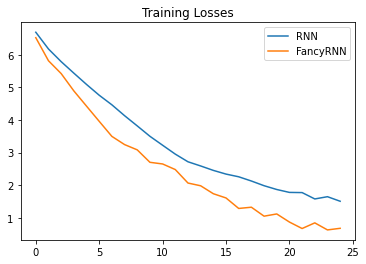

In [55]:
fig, ax = plt.subplots()
vanila_rnnlm_loss = np.array(vanila_rnnlm_loss)
fancy_rnnlm_loss = np.array(fancy_rnnlm_loss)
plt.plot(vanila_rnnlm_loss, label='RNN')
plt.plot(fancy_rnnlm_loss, label='FancyRNN')
plt.title("Training Losses")
plt.legend()

### Generating new text with RNNLM
Write the code to generate new text segments from the RNNLM. Produce several outputs from both VanilaRNN and FancyRNN to compare the quality of 2 models.

In [ ]:
def generate_text(rnnlm, seed_text, length, **params):
    """
    Params:
    rnnlm: the language model
    seed_text: a string of initial text
    length: the length of the generated text
    params: other params
    """
    seed_text = seed_text.lower().split() # ['students', 'open', 'their', 'bag']

    # translate words to id
    sentence_id = []
    for word in seed_text:
      sentence_id.append(word2id[word])    # ['123', '435', '135', '14']
    input_tensor = torch.LongTensor(sentence_id).to(device)

    # put seed_text through the language model
    for i in range(length):
      h0 = torch.zeros(1, hidden_size).to(device)
      output_text, hs = rnnlm(input_tensor, h0)
      output_text = output_text[-1]
      output_text = torch.squeeze(output_text)

      # take the word with the highest probability
      argmax_id = torch.argmax(output_text).item()
      sentence_id.append(argmax_id)            # ['123', '435', '135', '14', '78']
      input_tensor = torch.LongTensor(sentence_id).to(device)

    # translate id to words
    output_sentence = []
    for id in sentence_id:
      output_sentence.append(id2word[id])
    output_sentence = ' '.join(output_sentence)

    return output_sentence

In [ ]:
seed_text = input('Enter your initial text: ')
# output_text = generate_text(rnnlm=vanila_rnnlm, seed_text=seed_text, length=100)
output_text = generate_text(rnnlm=fancy_rnnlm, seed_text=seed_text, length=100)
print('{:<25}{:<30}'.format('Output sentence: ', output_text))

In [ ]:
# Test with sentences in the corpus
corpus_id = 52       # [0, corpus_size]
seed_length = 10     # [1, sentence_length]
output_length = 20
seed_text = corpus[corpus_id].split()
seed_text = seed_text[:seed_length]
seed_text = ' '.join(seed_text)

output_text = generate_text(rnnlm=vanila_rnnlm, seed_text=seed_text, length=output_length)
output_text = generate_text(rnnlm=fancy_rnnlm, seed_text=seed_text, length=output_length)

print('{:<20}{:<30}'.format('True sentence: ', corpus[corpus_id]))
print('{:<20}{:<30}'.format('Output sentence: ', output_text))
print('{:<20}{:<30}'.format('Output sentence: ', output_text))

### Perplexity (+2 bonus points)
Compute the perplexity of the models. The lower the perplexity, the higher your score.

In [ ]:
def perplexity(rnnlm, corpus):
    pass

In [ ]:
# perp = perplexity(rnnlm=rnnlm, corpus=wiki_corpus_test)
# print(perp)

## Word Embedding (1 point + 1 bonus point)

Now you have trained your RNNLM, the `torch.nn.Embedding` layer in your model stores the embeddings of words in the dictionary. You can use dimensionality reduction algorithms such as PCA and TSNE to visualize the word embeddings.
Produce a 2D plot of 100 to 1000 words and write a short analysis of the plot (e.g. the clusters of words with similar meaning, arithmetic operations you can apply on these words).

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [ ]:
word_embedding = vanila_rnn.embeddings
vocab = vocabulary
print(word_embedding)
print(len(vocab))

In [ ]:
word_embedding = (word_embedding.cpu().weight).detach().numpy()
word_embedding